### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup
!pip install lxml

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [4]:
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [5]:
df.shape

(98262, 6)

In [6]:
df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths      int64
dtype: object

In [7]:
df.isnull().sum()

date         0
county       0
state        0
fips      1179
cases        0
deaths       0
dtype: int64

In [8]:
df = df.drop(['fips'],axis=1)
df.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [9]:
df_pop = pd.read_excel('https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx',skiprows=5,header=None,usecols=[0,12])
df_pop.head()

,0,12
0,".Autauga County, Alabama",55869.0
1,".Baldwin County, Alabama",223234.0
2,".Barbour County, Alabama",24686.0
3,".Bibb County, Alabama",22394.0
4,".Blount County, Alabama",57826.0


In [10]:
df_pop = df_pop.rename(columns={0:'County, State',12:'Population Est. 2019'})
df_pop['County, State'] = df_pop['County, State'].str.replace(".","")
df_pop['County'], df_pop['State'] = df_pop['County, State'].str.split(', ',1).str
df_pop.drop(['County, State'],axis=1,inplace=True)
df_pop.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


,Population Est. 2019,County,State
0,55869.0,Autauga County,Alabama
1,223234.0,Baldwin County,Alabama
2,24686.0,Barbour County,Alabama
3,22394.0,Bibb County,Alabama
4,57826.0,Blount County,Alabama


In [11]:
df_pop.shape

(3148, 3)

In [12]:
df_pop.dtypes

Population Est. 2019    float64
County                   object
State                    object
dtype: object

In [13]:
df_pop.isnull().sum()

Population Est. 2019    6
County                  0
State                   2
dtype: int64

In [14]:
df_popnull = df_pop[pd.isnull(df_pop).any(axis=1)]
df_popnull

,Population Est. 2019,County,State
3142,NaN,Note: The estimates are based on the 2010 Cens...,2010 population due to the Count Question Reso...
3143,NaN,"Note: The 6,222 people in Bedford city","Virginia, which was an independent city as of ..."
3144,NaN,Suggested Citation:,NaN
3145,NaN,Annual Estimates of the Resident Population fo...,"2010 to July 1, 2019 (CO-EST2019-ANNRES)"
3146,NaN,Source: US Census Bureau,Population Division
3147,NaN,Release Date: March 2020,NaN


In [15]:
df_pop.drop(df_pop.index[3142:3148],inplace=True)
df_pop.shape

(3142, 3)

In [16]:
df_pop = df_pop.rename(columns={'County':'county','State':'state'})
df_pop.head()

,Population Est. 2019,county,state
0,55869.0,Autauga County,Alabama
1,223234.0,Baldwin County,Alabama
2,24686.0,Barbour County,Alabama
3,22394.0,Bibb County,Alabama
4,57826.0,Blount County,Alabama


In [17]:
df_pop_bystate = df_pop.groupby('state').sum()['Population Est. 2019']
df_pop_bystate = df_pop_bystate.to_frame()
df_pop_bystate.reset_index(inplace=True)
df_pop_bystate.head()

,state,Population Est. 2019
0,Alabama,4903185.0
1,Alaska,731545.0
2,Arizona,7278717.0
3,Arkansas,3017804.0
4,California,39512223.0


In [18]:
len(df['county'].unique())

1686

In [19]:
len(df['state'].unique())

55

In [20]:
df.describe()

,cases,deaths
count,98262.000000,98262.000000
mean,188.175805,8.113523
std,2228.540492,144.169073
min,0.000000,0.000000
25%,3.000000,0.000000
50%,9.000000,0.000000
75%,39.000000,1.000000
max,162348.000000,12067.000000


In [21]:
df2 = df.groupby('state').sum()['cases']
df3 = df.groupby('state').sum()['deaths']
df_bystate = pd.concat([df2, df3], axis=1)
df_bystate.reset_index(inplace=True)
df_bystate.head()

,state,cases,deaths
0,Alabama,117306,3552
1,Alaska,8380,171
2,Arizona,120683,4305
3,Arkansas,51565,942
4,California,821928,27274


In [22]:
df_bystate.shape

(55, 3)

In [23]:
df_bystate = pd.merge(df_bystate, df_pop_bystate, on='state')
df_bystate.head()

,state,cases,deaths,Population Est. 2019
0,Alabama,117306,3552,4903185.0
1,Alaska,8380,171,731545.0
2,Arizona,120683,4305,7278717.0
3,Arkansas,51565,942,3017804.0
4,California,821928,27274,39512223.0


In [24]:
df_bystate.shape

(51, 4)

In [25]:
df4 = df.groupby('county').sum()['cases']
df5 = df.groupby('county').sum()['deaths']
df_bycounty = pd.concat([df4, df5], axis=1)
df_bycounty.reset_index(inplace=True)
df_bycounty.head()

,county,cases,deaths
0,Abbeville,402,0
1,Acadia,2891,142
2,Accomack,1415,20
3,Ada,15123,251
4,Adair,2382,138


In [26]:
df_bycounty.shape

(1686, 3)

In [27]:
df_bycounty = pd.merge(df_bycounty, df_pop, on='county')
df_bycounty.head()

,county,cases,deaths,Population Est. 2019,state
0,Alexandria city,8447,169,159428.0,Virginia
1,Baltimore city,30531,964,593490.0,Maryland
2,Bethel Census Area,22,0,18386.0,Alaska
3,Bristol city,33,0,16762.0,Virginia
4,Buena Vista city,110,0,6478.0,Virginia


In [28]:
df_bycounty['Pop/1000']=df_bycounty['Population Est. 2019'].div(1000)
df_bycounty.head()

,county,cases,deaths,Population Est. 2019,state,Pop/1000
0,Alexandria city,8447,169,159428.0,Virginia,159.428
1,Baltimore city,30531,964,593490.0,Maryland,593.490
2,Bethel Census Area,22,0,18386.0,Alaska,18.386
3,Bristol city,33,0,16762.0,Virginia,16.762
4,Buena Vista city,110,0,6478.0,Virginia,6.478


In [29]:
df_bycounty['Cases/1000']=df_bycounty['cases'].div(df_bycounty['Pop/1000'])
df_bycounty.head()

,county,cases,deaths,Population Est. 2019,state,Pop/1000,Cases/1000
0,Alexandria city,8447,169,159428.0,Virginia,159.428,52.983165
1,Baltimore city,30531,964,593490.0,Maryland,593.490,51.443158
2,Bethel Census Area,22,0,18386.0,Alaska,18.386,1.196563
3,Bristol city,33,0,16762.0,Virginia,16.762,1.968739
4,Buena Vista city,110,0,6478.0,Virginia,6.478,16.980550


In [30]:
df_bycounty['Deaths/1000']=df_bycounty['deaths'].div(df_bycounty['Pop/1000'])
df_bycounty.head()

,county,cases,deaths,Population Est. 2019,state,Pop/1000,Cases/1000,Deaths/1000
0,Alexandria city,8447,169,159428.0,Virginia,159.428,52.983165,1.06004
1,Baltimore city,30531,964,593490.0,Maryland,593.490,51.443158,1.62429
2,Bethel Census Area,22,0,18386.0,Alaska,18.386,1.196563,0.00000
3,Bristol city,33,0,16762.0,Virginia,16.762,1.968739,0.00000
4,Buena Vista city,110,0,6478.0,Virginia,6.478,16.980550,0.00000


In [31]:
df_bystate['Pop/1000']=df_bystate['Population Est. 2019'].div(1000)
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000
0,Alabama,117306,3552,4903185.0,4903.185
1,Alaska,8380,171,731545.0,731.545
2,Arizona,120683,4305,7278717.0,7278.717
3,Arkansas,51565,942,3017804.0,3017.804
4,California,821928,27274,39512223.0,39512.223


In [32]:
df_bystate['Cases/1000']=df_bystate['cases'].div(df_bystate['Pop/1000'])
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000
0,Alabama,117306,3552,4903185.0,4903.185,23.924449
1,Alaska,8380,171,731545.0,731.545,11.455208
2,Arizona,120683,4305,7278717.0,7278.717,16.580257
3,Arkansas,51565,942,3017804.0,3017.804,17.086928
4,California,821928,27274,39512223.0,39512.223,20.801867


In [33]:
df_bystate['Deaths/1000']=df_bystate['deaths'].div(df_bystate['Pop/1000'])
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267


In [34]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_geographic_centers_of_the_United_States').text
soup = BeautifulSoup(source, 'html.parser')

In [35]:
My_table = soup.find_all('table',{'class':'wikitable sortable'})[1]

In [36]:
tableheader = My_table.find_all('th')
tableheader

[<th>State or<br/>federal district
 </th>,
 <th>Location
 </th>,
 <th>Coordinates
 </th>]

In [37]:
table_rows = My_table.find_all('tr')
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])
df_stateloc = pd.DataFrame(data)
df_stateloc.drop([0],inplace=True)
df_stateloc.drop([1],axis=1,inplace=True)
df_stateloc = df_stateloc.rename(columns={0:'state',2:'coordinates'})
df_stateloc.head()

,state,coordinates
1,Alabama,32°46′46″N 86°49′43″W﻿ / ﻿32.7794°N 86.8287°W﻿...
2,Alaska,64°04′07″N 152°16′42″W﻿ / ﻿64.0685°N 152.2782°...
3,Arizona,34°16′28″N 111°39′37″W﻿ / ﻿34.2744°N 111.6602°...
4,Arkansas,34°53′38″N 92°26′33″W﻿ / ﻿34.8938°N 92.4426°W﻿...
5,California,37°11′03″N 119°28′11″W﻿ / ﻿37.1841°N 119.4696°...


In [38]:
df_bystate = pd.merge(df_bystate, df_stateloc, on='state')
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,coordinates
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32°46′46″N 86°49′43″W﻿ / ﻿32.7794°N 86.8287°W﻿...
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64°04′07″N 152°16′42″W﻿ / ﻿64.0685°N 152.2782°...
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34°16′28″N 111°39′37″W﻿ / ﻿34.2744°N 111.6602°...
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34°53′38″N 92°26′33″W﻿ / ﻿34.8938°N 92.4426°W﻿...
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37°11′03″N 119°28′11″W﻿ / ﻿37.1841°N 119.4696°...


In [39]:
df_bystate.shape

(51, 8)

In [40]:
df_bystate['c1'], df_bystate['c2'] = df_bystate['coordinates'].str.split(' / ',1).str
df_bystate.drop(['coordinates'],axis=1,inplace=True)
df_bystate.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,c1,c2
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32°46′46″N 86°49′43″W﻿,﻿32.7794°N 86.8287°W﻿ / 32.7794; -86.8287﻿ (Ce...
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64°04′07″N 152°16′42″W﻿,﻿64.0685°N 152.2782°W﻿ / 64.0685; -152.2782﻿ (...
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34°16′28″N 111°39′37″W﻿,﻿34.2744°N 111.6602°W﻿ / 34.2744; -111.6602﻿ (...
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34°53′38″N 92°26′33″W﻿,﻿34.8938°N 92.4426°W﻿ / 34.8938; -92.4426﻿ (Ce...
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37°11′03″N 119°28′11″W﻿,﻿37.1841°N 119.4696°W﻿ / 37.1841; -119.4696﻿ (...


In [41]:
df_bystate.drop(['c1'],axis=1,inplace=True)
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,c2
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,﻿32.7794°N 86.8287°W﻿ / 32.7794; -86.8287﻿ (Ce...
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,﻿64.0685°N 152.2782°W﻿ / 64.0685; -152.2782﻿ (...
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,﻿34.2744°N 111.6602°W﻿ / 34.2744; -111.6602﻿ (...
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,﻿34.8938°N 92.4426°W﻿ / 34.8938; -92.4426﻿ (Ce...
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,﻿37.1841°N 119.4696°W﻿ / 37.1841; -119.4696﻿ (...


In [42]:
df_bystate['c3'], df_bystate['c4'] = df_bystate['c2'].str.split(' / ',1).str
df_bystate.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,c2,c3,c4
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,﻿32.7794°N 86.8287°W﻿ / 32.7794; -86.8287﻿ (Ce...,﻿32.7794°N 86.8287°W﻿,32.7794; -86.8287﻿ (Center of Alabama)
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,﻿64.0685°N 152.2782°W﻿ / 64.0685; -152.2782﻿ (...,﻿64.0685°N 152.2782°W﻿,64.0685; -152.2782﻿ (Center of Alaska)
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,﻿34.2744°N 111.6602°W﻿ / 34.2744; -111.6602﻿ (...,﻿34.2744°N 111.6602°W﻿,34.2744; -111.6602﻿ (Center of Arizona)
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,﻿34.8938°N 92.4426°W﻿ / 34.8938; -92.4426﻿ (Ce...,﻿34.8938°N 92.4426°W﻿,34.8938; -92.4426﻿ (Center of Arkansas)
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,﻿37.1841°N 119.4696°W﻿ / 37.1841; -119.4696﻿ (...,﻿37.1841°N 119.4696°W﻿,37.1841; -119.4696﻿ (Center of California)


In [43]:
df_bystate.drop(['c2','c3'],axis=1,inplace=True)
df_bystate.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,c4
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794; -86.8287﻿ (Center of Alabama)
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685; -152.2782﻿ (Center of Alaska)
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744; -111.6602﻿ (Center of Arizona)
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938; -92.4426﻿ (Center of Arkansas)
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841; -119.4696﻿ (Center of California)


In [44]:
df_bystate['latitude'], df_bystate['longitude'] = df_bystate['c4'].str.split(' ',1).str
df_bystate.drop(['c4'],axis=1,inplace=True)
df_bystate.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794;,-86.8287﻿ (Center of Alabama)
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685;,-152.2782﻿ (Center of Alaska)
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744;,-111.6602﻿ (Center of Arizona)
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938;,-92.4426﻿ (Center of Arkansas)
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841;,-119.4696﻿ (Center of California)


In [45]:
df_bystate['longitude2'], df_bystate['longitude_text'] = df_bystate['longitude'].str.split(' ',1).str
df_bystate.drop(['longitude_text','longitude'],axis=1,inplace=True)
df_bystate.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude2
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794;,-86.8287﻿
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685;,-152.2782﻿
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744;,-111.6602﻿
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938;,-92.4426﻿
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841;,-119.4696﻿


In [46]:
df_state = df_bystate.copy()
df_state = df_state.rename(columns={'longitude2':'longitude'})
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794;,-86.8287﻿
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685;,-152.2782﻿
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744;,-111.6602﻿
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938;,-92.4426﻿
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841;,-119.4696﻿


In [47]:
df_state.dtypes

state                    object
cases                     int64
deaths                    int64
Population Est. 2019    float64
Pop/1000                float64
Cases/1000              float64
Deaths/1000             float64
latitude                 object
longitude                object
dtype: object

In [48]:
df_state['latitude']=df_state['latitude'].astype('str')
df_state['latitude']=df_state['latitude'].str.replace(";","")
df_state['longitude']=df_state['longitude'].astype('str')
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794,-86.8287﻿
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685,-152.2782﻿
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744,-111.6602﻿
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938,-92.4426﻿
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841,-119.4696﻿


In [49]:
df_state['latitude'] = pd.to_numeric(df_state['latitude'], errors='coerce')
df_state['longitude'] = df_state['longitude'].str.replace('\ufeff', '').astype('float')
df_state.head()

,state,cases,deaths,Population Est. 2019,Pop/1000,Cases/1000,Deaths/1000,latitude,longitude
0,Alabama,117306,3552,4903185.0,4903.185,23.924449,0.724427,32.7794,-86.8287
1,Alaska,8380,171,731545.0,731.545,11.455208,0.233752,64.0685,-152.2782
2,Arizona,120683,4305,7278717.0,7278.717,16.580257,0.591450,34.2744,-111.6602
3,Arkansas,51565,942,3017804.0,3017.804,17.086928,0.312148,34.8938,-92.4426
4,California,821928,27274,39512223.0,39512.223,20.801867,0.690267,37.1841,-119.4696


In [50]:
lat_us = 39.8333333
lon_us = -98.585522
print('The geographical coordinates of US are {}, {}'.format(lat_us, lon_us))

The geographical coordinates of US are 39.8333333, -98.585522


In [51]:
map_us_cases1000 = folium.Map(location=[lat_us, lon_us], zoom_start=5)

# add markers to map
for lat, lng, case1000, state in zip(df_state['latitude'], df_state['longitude'], df_state['Cases/1000'],df_state['state'] ):
    label = '{}{}{}'.format(case1000,' ',state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=case1000/4,
        popup=label,
        color='black',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        parse_html=False).add_to(map_us_cases1000)  
    
map_us_cases1000

{'whiskers': [<matplotlib.lines.Line2D at 0x7f91084b6320>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91084b69b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91084abfd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f91084bc080>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f91084bc3c8>],
 'means': []}

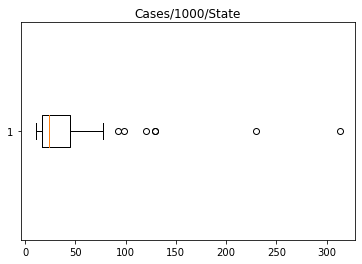

In [53]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cases/1000/State')
ax1.boxplot(df_state['Cases/1000'],vert=False)

In [56]:
map_us_deaths1000 = folium.Map(location=[lat_us, lon_us], zoom_start=5)

# add markers to map
for lat, lng, death1000, state in zip(df_state['latitude'], df_state['longitude'], df_state['Deaths/1000'],df_state['state']):
    label = '{}{}{}'.format(death1000,' ',state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=death1000*5,
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.5,
        parse_html=False).add_to(map_us_deaths1000)  
    
map_us_deaths1000

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9108402dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f91084104a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9108402ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9108410b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9108410e80>],
 'means': []}

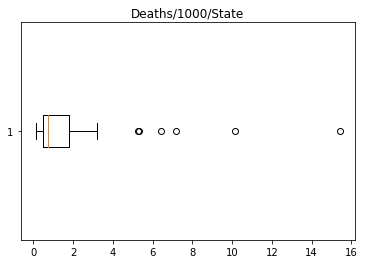

In [54]:
fig1, ax1 = plt.subplots()
ax1.set_title('Deaths/1000/State')
ax1.boxplot(df_state['Deaths/1000'],vert=False)

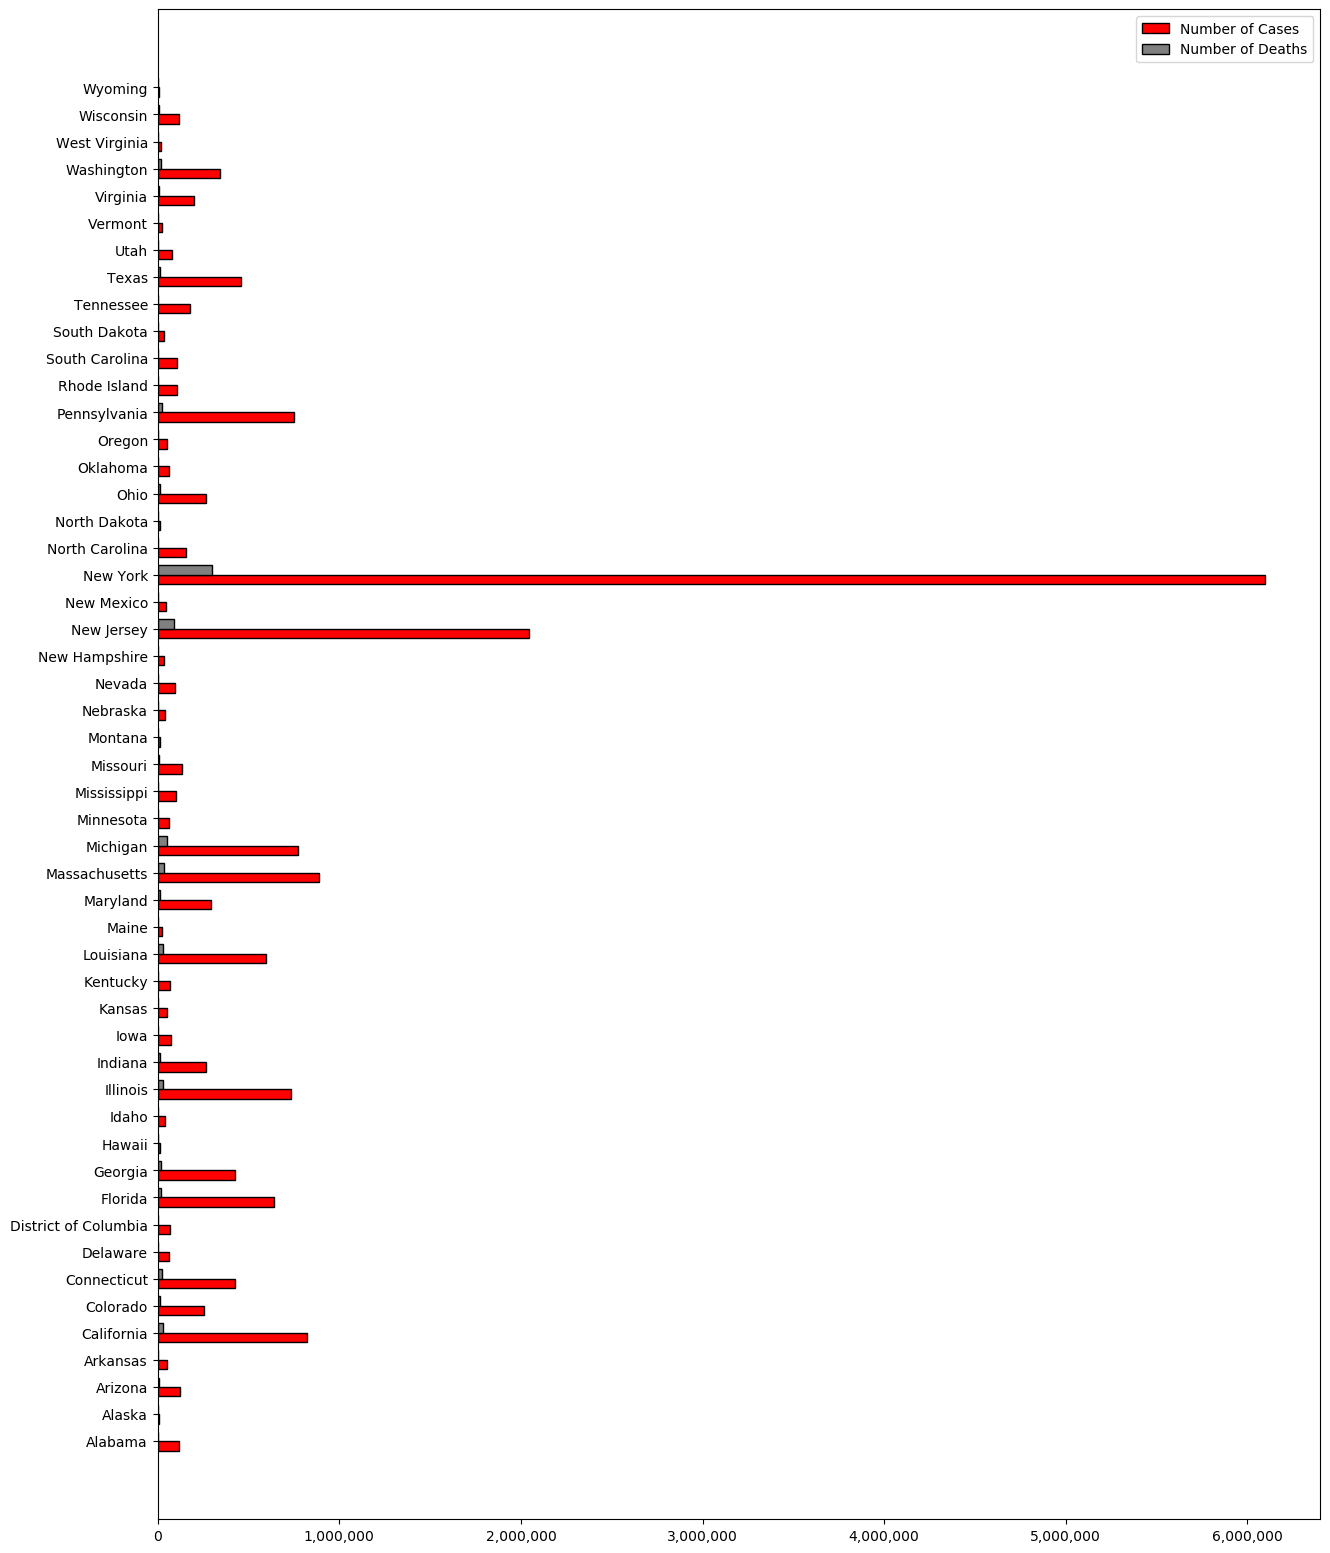

In [81]:
import matplotlib
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(15,20),dpi=100)
    
width = 0.35
ind = np.arange(len(df_state))

ax.barh(ind,df_state['cases'],width,color='red',edgecolor='black',label='Number of Cases')
ax.barh(ind+width,df_state['deaths'],width,color='grey',edgecolor='black',label='Number of Deaths')

ax.set_yticks(ind+width/2)
ax.set_yticklabels(df_state['state'])
ax.legend(loc='best')

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

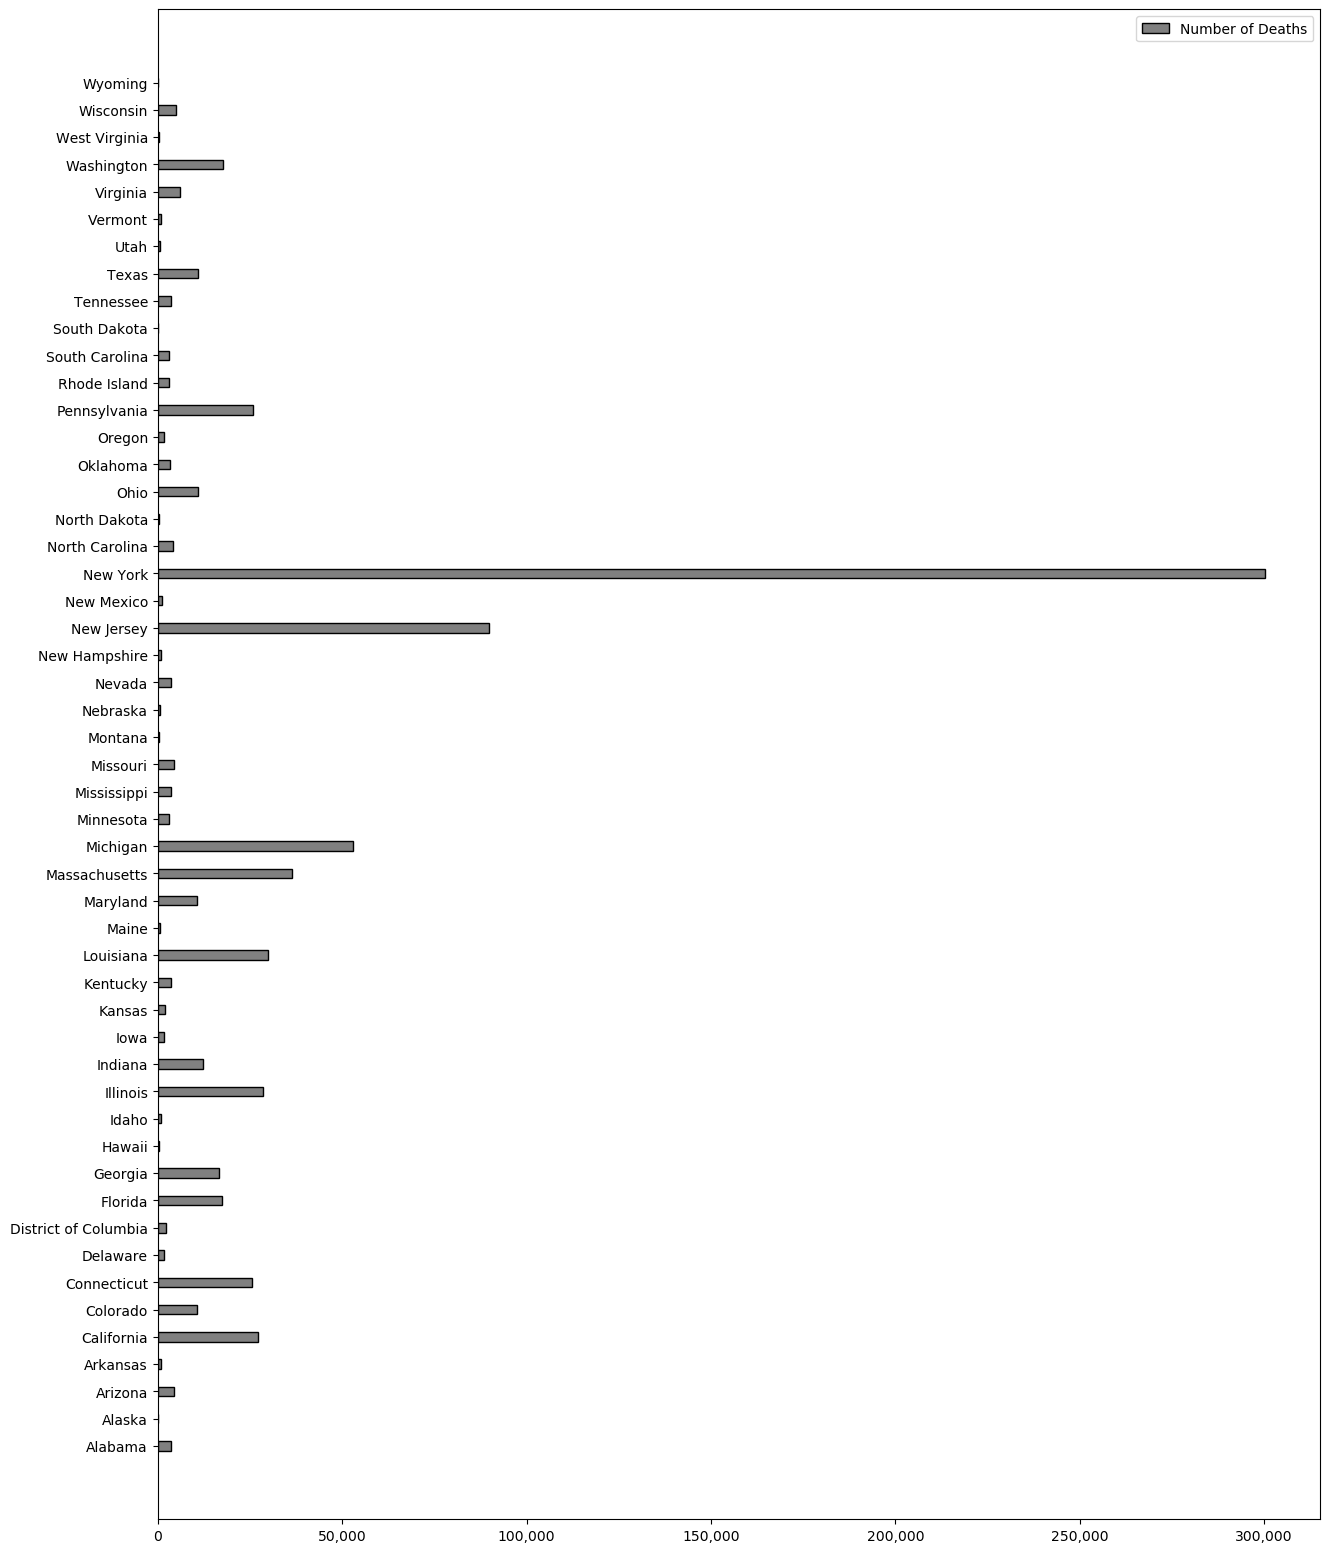

In [87]:
fig, ax = plt.subplots(figsize=(15,20),dpi=100)
    
width = 0.35
ind = np.arange(len(df_state))

ax.barh(ind,df_state['deaths'],width,color='grey',edgecolor='black',label='Number of Deaths')

ax.set_yticks(ind)
ax.set_yticklabels(df_state['state'])
ax.legend(loc='best')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [88]:
#creating a dataframe just for the clustering (we need only numbers)
df_clusters = df_state[['Cases/1000','Deaths/1000']]
df_clusters.head()

,Cases/1000,Deaths/1000
0,23.924449,0.724427
1,11.455208,0.233752
2,16.580257,0.591450
3,17.086928,0.312148
4,20.801867,0.690267


In [89]:
#Preprocessing of the data by scaling with Standard Scaler method
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[-0.38211431, -0.3874153 ],
       [-0.60773718, -0.56519706],
       [-0.51500272, -0.4355955 ],
       [-0.50583483, -0.5367927 ],
       [-0.43861542, -0.39979206],
       [-0.02070893,  0.01167885],
       [ 1.35357806,  1.95352707],
       [ 0.29949151, -0.06386011],
       [ 0.862875  ,  0.51189902],
       [-0.27591843, -0.35465548],
       [-0.08909697, -0.08525627],
       [-0.62013482, -0.58796255],
       [-0.38403349, -0.44531927],
       [ 0.23136844,  0.16519978],
       [-0.10363812,  0.01724891],
       [-0.39901717, -0.45661852],
       [-0.50575774, -0.39692735],
       [-0.5347596 , -0.36572178],
       [ 1.51418004,  1.67922775],
       [-0.51436172, -0.44719513],
       [ 0.06045295, -0.01654466],
       [ 1.52079309,  1.25961883],
       [ 0.58877836,  1.27395212],
       [-0.62262799, -0.44513997],
       [-0.19401617, -0.21782986],
       [-0.41409219, -0.38535612],
       [-0.61464585, -0.562427  ],
       [-0.45455733, -0.50960015],
       [-0.25909089,

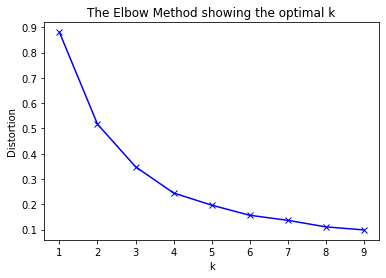

In [90]:
#using Elbow method in order to define optimal k value for clusterint (k will be the number of clusters)
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [91]:
# set number of clusters based on the largest shift on the line (k should be 2)
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:40]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

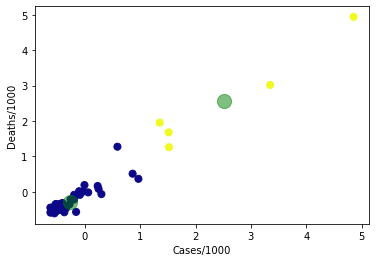

In [95]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5);
plt.xlabel('Cases/1000')
plt.ylabel('Deaths/1000')
plt.show()

In [57]:
dff = df.copy()
dff.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [58]:
dff.dtypes

date      object
county    object
state     object
cases      int64
deaths     int64
dtype: object

In [59]:
dff_base = dff[['date','state','cases','deaths']]
dff_base.head()

,date,state,cases,deaths
0,2020-01-21,Washington,1,0
1,2020-01-22,Washington,1,0
2,2020-01-23,Washington,1,0
3,2020-01-24,Illinois,1,0
4,2020-01-24,Washington,1,0


In [69]:
dffcases = dff_base[['date','state','cases']]
dffcases['no_cumulative'] = dffcases.groupby(['state'])['cases'].apply(lambda x: x.cumsum())
dffcases.head()

,date,state,cases,no_cumulative
0,2020-01-21,Washington,1,1
1,2020-01-22,Washington,1,2
2,2020-01-23,Washington,1,3
3,2020-01-24,Illinois,1,1
4,2020-01-24,Washington,1,4


In [70]:
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.colors as mc
import colorsys
from random import randint
import re

In [71]:
for p in range(3):
    i = 0
    while i < len(dffcases.columns):
        try:
            a = np.array(dffcases.iloc[:, i + 1])
            b = np.array(dffcases.iloc[:, i + 2])
            c = (a + b) / 2
            dffcases.insert(i+2, str(dffcases.iloc[:, i + 1].name) + '^' + str(len(dffcases.columns)), c)
        except:
            print(f"\n  Interpolation No. {p + 1} done...")
        i += 2

dffcases = pd.melt(dffcases, id_vars = 'state', var_name = 'date')


  Interpolation No. 1 done...

  Interpolation No. 1 done...

  Interpolation No. 2 done...

  Interpolation No. 2 done...

  Interpolation No. 3 done...

  Interpolation No. 3 done...


In [72]:
frames_list = dffcases["date"].unique().tolist()
for i in range(10):
    frames_list.append(dffcases['date'].iloc[-1])

In [73]:
def transform_color(color, amount = 0.5):

    try:
        c = mc.cnames[color]
    except:
        c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

all_names = dffcases['state'].unique().tolist()
random_hex_colors = []
for i in range(len(all_names)):
    random_hex_colors.append('#' + '%06X' % randint(0, 0xFFFFFF))

rgb_colors = [transform_color(i, 1) for i in random_hex_colors]
rgb_colors_opacity = [rgb_colors[x] + (0.825,) for x in range(len(rgb_colors))]
rgb_colors_dark = [transform_color(i, 1.12) for i in random_hex_colors]

In [74]:
num_of_elements = 8

def draw_barchart(date):

    dffcases_frame = dffcases[dffcases['date'].eq(date)].sort_values(by = 'cases', ascending = True).tail(num_of_elements)
    ax.clear()

    normal_colors = dict(zip(dffcases['state'].unique(), rgb_colors_opacity))
    dark_colors = dict(zip(dffcases['state'].unique(), rgb_colors_dark))
    
    ax.barh(dffcases_frame['state'], dffcases_frame['cases'], color = [normal_colors[x] for x in dffcases_frame['state']], height = 0.8,
            edgecolor =([dark_colors[x] for x in dffcases_frame['state']]), linewidth = '6')

    dx = float(dffcases_frame['cases'].max())

    for i, (cases, name) in enumerate(zip(dffcases_frame['cases'], dffcases_frame['state'])):
        ax.text(cases + dx, i + (num_of_elements / 50), '    ' + name,
        size = 36, weight = 'bold', ha = 'left', va = 'center', fontdict = {'fontname': 'Trebuchet MS'})
        ax.text(cases + dx, i - (num_of_elements / 50), f'    {cases:,.0f}', size = 36, ha = 'left', va = 'center')

    time_unit_displayed = re.sub(r'\^(.*)', r'', str(date))
    ax.text(1.0, 1.14, time_unit_displayed, transform = ax.transAxes, color = '#666666',
            size = 62, ha = 'right', weight = 'bold', fontdict = {'fontname': 'Trebuchet MS'})
    ax.text(-0.005, 1.06, 'Cases by State', transform = ax.transAxes, size = 30, color = '#666666')
    ax.text(-0.005, 1.14, 'Total Cases by State', transform = ax.transAxes,
            size = 62, weight = 'bold', ha = 'left', fontdict = {'fontname': 'Trebuchet MS'})

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis = 'x', colors = '#666666', labelsize = 28)
    ax.set_yticks([])
    ax.set_axisbelow(True)
    ax.margins(0, 0.01)
    ax.grid(which = 'major', axis = 'x', linestyle = '-')

    plt.locator_params(axis = 'x', nbins = 4)
    plt.box(False)
    plt.subplots_adjust(left = 0.075, right = 0.75, top = 0.825, bottom = 0.05, wspace = 0.2, hspace = 0.2)

In [75]:
animator = animation.FuncAnimation(fig, draw_barchart, frames = frames_list)
animator.save("Racing Bar Chart.mp4", fps = 20, bitrate = 1800)

KeyError: 'cases'